In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd
from math import log
import urllib.request
from tqdm import tqdm
from sklearn import svm
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# amazon = pd.read_csv('/content/drive/My Drive/amazon_reviews.csv')
# binary_airline = pd.read_csv('/content/drive/My Drive/binary_air_review.csv')
# binary_hotel = pd.read_csv('/content/drive/My Drive/hotel-reviews.csv')
# clothing = pd.read_csv('/content/drive/My Drive/clothing.csv')
# movie = pd.read_csv('/content/drive/My Drive/train.csv')
# steam = pd.read_csv('/content/drive/My Drive/steam.csv')
yelp = pd.read_csv('/content/drive/My Drive/yelp.csv')

In [5]:
# sorting = amazon.sort_values(['label'])                     ## contents
# sorting = binary_airline.sort_values(['rating'])            ## comment
# sorting = binary_hotel.sort_values(['Is_Response'])         ## Description
# sorting = clothing.sort_values(['Recommended IND'])         ## Review Text
# sorting = movie.sort_values(['sentiment'])                  ## text
# sorting = steam.sort_values(['user_suggestion'])            ## user_review
sorting = yelp.sort_values(['rating'])                      ## review

In [6]:
sorting

,rating,review
18999,1,My husband was in the hospital for blood clots...
20704,1,DON'T GO!!! \nWorst experience ever!!! \nYou p...
20703,1,This is hard to review. The reason being is t...
20701,1,"I don't really get the whole \""sexy\"" thing wi..."
20700,1,I used to come here when I lived in student ha...
...,...,...
22104,2,Best local pizza! Just order the Cheeseburger ...
22103,2,"Great food, mediocre service, very long wait t..."
22102,2,I absolutely love this sushi place it's right ...
7652,2,Friends had gone on our last trip to LV and I ...


In [7]:
## 본문부분 열 이름과 점수부분 열 이름 입력

contents_name = "review"
label_name = "rating"

In [8]:
def data_loading(sorting, contents_name, label_name):

  review_ = sorting.reset_index()
  # 라벨 인코더 생성
  encoder = LabelEncoder()

  # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
  encoder.fit(review_[label_name])
  target_encoded = encoder.transform(review_[label_name])

  contents = list(np.array(review_[contents_name].tolist()))
  label = list(target_encoded)
  cnts_N = contents[:2000]+contents[-2000:]   ## X_train
  label_N = label[:2000]+label[-2000:]        ## y_train

  ## train data를 제외한 test data
  test_dict = {'document':contents[2000:-2000],"label":label[2000:-2000]}
  test_df = pd.DataFrame(test_dict)

  np.random.seed(0)

  df_shuffled=test_df.iloc[np.random.permutation(test_df.index)].reset_index(drop=True)
  df_shuffled

  tdata = df_shuffled['document']
  tlabel = df_shuffled['label']

  return cnts_N, label_N, tdata, tlabel

In [9]:
## train test split과 같이 진행

train_X, train_Y, test_X, test_Y = data_loading(sorting, contents_name, label_name)

In [10]:
def preprocessing(data):

    from nltk import FreqDist
    from nltk.stem.snowball import SnowballStemmer
    snowball = SnowballStemmer('english')

    normalized_text = []  ## 괄호 제거 및 문자이외의 데이터 제거
    for scr in data:
        scr = re.sub('\(', ' ', scr)
        scr = re.sub('\)', ' ', scr)
        scr = re.sub('[^ a-zA-Zㄱ-힗]', '', scr)
        normalized_text.append(scr.lower())

    result = [word_tokenize(sentence) for sentence in normalized_text]  ## 토큰화

    ## 단어 빈도 수 계산( 10번이상 등장하지 않는 단어 stopword에 포함 )
    vocab = list(set(w for i in result for w in i))
    vocab.sort()

    check_freq = []
    for line in result:
        for wd in line:
            check_freq.append(wd)

    fdist = FreqDist(check_freq)

    low_freq = []
    for i in vocab:
        if fdist[i] < 10:
            low_freq.append(i)

    stop_words = set(stopwords.words('english'))
    stop_words = list(stop_words)
    for i in low_freq:
        stop_words.append(i)

    ## stopwords 제거 및 stemming
    except_stopword = []
    for st in result:
        temp = []
        for tk in st:
            if tk not in stop_words:
                temp.append(snowball.stem(tk))
        except_stopword.append(temp)
    
    return except_stopword

In [11]:
## train data 토큰화

train_tokens = preprocessing(train_X)

리뷰의 최대 길이 : 381
리뷰의 평균 길이 : 56.27275


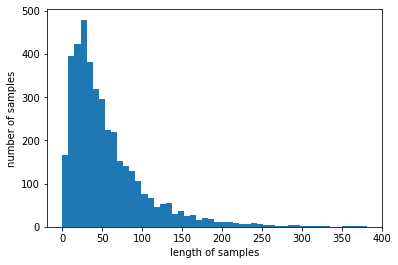

In [12]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_tokens))
print('리뷰의 평균 길이 :',sum(map(len, train_tokens))/len(train_tokens))
plt.hist([len(s) for s in train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
vocab = list(set(w for i in train_tokens for w in i ))
vocab.sort()

In [14]:
print('단어의 갯수는 총 %d개 이다'%(len(vocab)))

단어의 갯수는 총 2451개 이다


In [15]:
## 전처리 된 단어들을 다시 문장화

def corpus(tokens):
  corp = []
  for sent in tokens:
    tmp = " ".join(sent)
    corp.append(tmp)

  return corp

train_corp = corpus(train_tokens)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import operator

## Support Vector Classifier를 이용한 사전생성

def score_importance(corpus, label):

  from sklearn import svm
  vector = TfidfVectorizer()
  tfidf_matrix = vector.fit_transform(corpus).toarray()

  svm = svm.SVC(C=1.0, kernel='linear',degree = 1, probability=True)
  svm.fit(tfidf_matrix, label)
  importance = svm.coef_

  v_dict = vector.vocabulary_
  rv_dict = {}
  for k,v in v_dict.items():
    rv_dict[v] = k

  score_dict = {}
  for i,v in enumerate(importance[0]):
    score_dict[rv_dict[i]] = v

  score_dict = sorted(score_dict.items(), key=operator.itemgetter(1))
  
  return dict(score_dict)

score_dict = score_importance(train_corp, train_Y)

In [20]:
score_dict

{'worst': -3.1106226629179647,
 'terribl': -2.9491912124357196,
 'mediocr': -2.8267643185834808,
 'ok': -2.590395058688986,
 'bad': -2.4671391697152654,
 'bland': -2.4155553109867305,
 'disappoint': -2.378071388775733,
 'poor': -2.329358412296626,
 'noth': -2.321252273979762,
 'expens': -2.1013003109173507,
 'overpr': -2.055758394486449,
 'horribl': -2.010919028575538,
 'dri': -1.9805443280859518,
 'disgust': -1.9206655362201541,
 'aw': -1.8297887354798514,
 'rude': -1.826998891859657,
 'lack': -1.7902230555028706,
 'pay': -1.7439090707376166,
 'suck': -1.7199055278828879,
 'mayb': -1.7083951811632676,
 'unfortun': -1.701431498041344,
 'almost': -1.6919812361230684,
 'guess': -1.675065946234063,
 'would': -1.6628195825712424,
 'paid': -1.6178851875157583,
 'wasnt': -1.6151201136232454,
 'two': -1.59721222919896,
 'said': -1.5957047922568794,
 'wast': -1.5601982632934692,
 'sorri': -1.555637947138485,
 'unless': -1.5458642959716713,
 'anymor': -1.5226248439638699,
 'never': -1.518241792

In [21]:
## 사전 정규화

def dict_normalize(score_dict):
  dict_ = score_dict.copy()
  key = list(dict_.keys())
  value = np.array(list(dict_.values()))
  value /= np.max(abs(value))
  normalize_dict = {k:v for k, v in zip(key, value)} 
  return normalize_dict

normalize_dict = dict_normalize(score_dict)

In [ ]:
## 사전에서 coefficient가 0.1 이상의 단어들을 긍정 혹은 부정으로 분리

pos_ = {}
neg_ = {}

for (k,v) in score_dict:
# for k, v in normalize_dict.items():
  if abs(v)> 0.1:
    if v < 0:
      pos_[k] = v
    elif v > 0:
      neg_[k] = v
    else :
      None

print(len(pos_),len(neg_))

958 893


In [ ]:
sorted(pos_.items(),reverse=False ,key=operator.itemgetter(1))

[('instead', -2.36226700816096),
 ('ruin', -2.2949313958452935),
 ('wast', -2.285412972856424),
 ('spawn', -2.255371329886774),
 ('noth', -2.243987656797461),
 ('worst', -2.208652107624983),
 ('broken', -2.1793688272315843),
 ('fallout', -2.170272978765479),
 ('moba', -2.1236260668284648),
 ('sniper', -2.0480161788188873),
 ('whole', -2.0148891035055327),
 ('pay', -1.9921180342793867),
 ('wasnt', -1.9165441779940129),
 ('gun', -1.877262649796373),
 ('even', -1.8352319180935988),
 ('terribl', -1.8295471735703919),
 ('dweller', -1.7389400730520221),
 ('sad', -1.73670096000283),
 ('smite', -1.7208977173339468),
 ('slow', -1.7101385583104698),
 ('uninstal', -1.6905474026049956),
 ('reviewi', -1.6860181475293572),
 ('ban', -1.6813013112389745),
 ('forc', -1.6555156074488835),
 ('cost', -1.6517635503342305),
 ('cant', -1.6222017101163824),
 ('camp', -1.6053398343221157),
 ('develop', -1.5816219749294587),
 ('shot', -1.5559270910371297),
 ('poor', -1.5556823767095842),
 ('went', -1.5453983714

In [ ]:
sorted(neg_.items(),reverse=True ,key=operator.itemgetter(1))

[('addict', 2.7538475129732296),
 ('best', 2.6355636858686977),
 ('smash', 2.5776833376078265),
 ('great', 2.5077551868561736),
 ('dungeon', 2.477267923865855),
 ('amaz', 2.3324905040162447),
 ('charact', 2.33143850474479),
 ('learn', 2.0684021755693114),
 ('simul', 2.0352944424991444),
 ('fun', 2.0336269358483214),
 ('bit', 2.009023225214053),
 ('easi', 2.005008078942649),
 ('elsword', 1.922125741319682),
 ('complain', 1.8445094273956606),
 ('job', 1.7567829414039995),
 ('rotmg', 1.7410212925660185),
 ('improv', 1.7324394026742025),
 ('awesom', 1.6796666449253714),
 ('fantast', 1.6524269243398537),
 ('perfect', 1.638396778818709),
 ('style', 1.6323992462591916),
 ('say', 1.6192924677817586),
 ('easier', 1.5828507569616277),
 ('bros', 1.5750734291327537),
 ('overal', 1.5400603360366674),
 ('life', 1.5159253593816289),
 ('lane', 1.5117017518845484),
 ('elder', 1.4814613019794838),
 ('trade', 1.475583805058011),
 ('item', 1.454614266921168),
 ('freedom', 1.4462797788516069),
 ('good', 1.

In [ ]:
test_1 = test_X[:1000]

In [ ]:
test_tokens = preprocessing(test_1)

In [ ]:
## 기준점수가 0이 아닌경우가 있다...
## test_set labeling 과정...

def semi_labeling(tkns):
  test_label = []
  for tokens in tkns:
    p = 0
    n = 0
    for t in tokens:
      if t in pos_.keys():
        p+=pos_[t]
      elif t in neg_.keys():
        n+=neg_[t]
      else:
        None
    
    if p+n <= 0:
      test_label.append(0)
    elif p+n > 0:
      test_label.append(1)
  
  return test_label

test_label = semi_labeling(test_tokens)

In [ ]:
## 예측값과 실제값 정확도 측정

def cal_acc(y, pred):
  accuracy = np.mean(np.equal(y,pred))

  return accuracy

acc = cal_acc(test_Y[:1000],test_label)
acc

In [ ]:
## 추가 생성된 사전에서 threshold 이상의 값을 가지는 단어만 본 사전에 업데이트 진행

def update_dict(score_dict, threshold): 

  p_count = 0
  n_count = 0

  for (k,v) in score_dict.items():
    if abs(v) > threshold:
      if (k not in pos_) or (k not in neg_):
        if v < 0:
          pos_[k] = v
          p_count+=1
        else:
          neg_[k] = v
          n_count+=1
      else:
        if (v < 0) and (pos_[k] > v):
          pos_[k] = v
          p_count+=1
        elif (v > 0) and (neg_[k] < v): 
          neg_[k] = v
          n_count+=1
        else:
          None

  print('긍정단어 %d개, 부정단어 %d개 업데이트'%(p_count, n_count))

  return pos_, neg_

In [ ]:
## 뒤에서 부터 1000개 validation data 생성

val_X = preprocessing(test_X[-1000:])
val_y = np.array(test_Y[-1000:])

In [ ]:
p = len(pos_)
n = len(neg_)

v_acc = []
t_acc = []
t_acc.append(acc)

for i in tqdm(range(1,35)):
  test_cnts = test_X[1000*i:1000*(i+1)]
  test_tokens = preprocessing(test_cnts)
  test_corp = corpus(test_tokens)
  test_label = semi_labeling(test_tokens)
  real_label = np.array(test_Y[1000*i:1000*(i+1)])

  score_dict = score_importance(test_corp, test_label)
  normalize_dict = dict_normalize(score_dict)
  pos_, neg_ = update_dict(normalize_dict,0.5)
  
  print("test set 정확도 :",cal_acc(real_label,test_label))
  t_acc.append(cal_acc(real_label,test_label))

  prediction = semi_labeling(val_X)
  print(Counter(prediction))
  acc = cal_acc(val_y,prediction)
  v_acc.append(acc)

  print("#"*40)
  print('사전 업데이트 후 정확도',acc)
  print("#"*40)

  3%|▎         | 1/34 [00:03<01:50,  3.36s/it]

긍정단어 7개, 부정단어 4개 업데이트
test set 정확도 : 0.853
Counter({1: 723, 0: 277})
########################################
사전 업데이트 후 정확도 0.825
########################################


  6%|▌         | 2/34 [00:06<01:48,  3.40s/it]

긍정단어 4개, 부정단어 3개 업데이트
test set 정확도 : 0.839
Counter({1: 699, 0: 301})
########################################
사전 업데이트 후 정확도 0.811
########################################


  9%|▉         | 3/34 [00:10<01:47,  3.48s/it]

긍정단어 6개, 부정단어 3개 업데이트
test set 정확도 : 0.816
Counter({1: 682, 0: 318})
########################################
사전 업데이트 후 정확도 0.798
########################################


 12%|█▏        | 4/34 [00:14<01:45,  3.51s/it]

긍정단어 3개, 부정단어 2개 업데이트
test set 정확도 : 0.802
Counter({1: 687, 0: 313})
########################################
사전 업데이트 후 정확도 0.805
########################################


 15%|█▍        | 5/34 [00:17<01:43,  3.55s/it]

긍정단어 3개, 부정단어 4개 업데이트
test set 정확도 : 0.82
Counter({1: 695, 0: 305})
########################################
사전 업데이트 후 정확도 0.813
########################################


 18%|█▊        | 6/34 [00:21<01:39,  3.57s/it]

긍정단어 3개, 부정단어 1개 업데이트
test set 정확도 : 0.796
Counter({1: 704, 0: 296})
########################################
사전 업데이트 후 정확도 0.816
########################################


 21%|██        | 7/34 [00:24<01:35,  3.55s/it]

긍정단어 2개, 부정단어 1개 업데이트
test set 정확도 : 0.808
Counter({1: 704, 0: 296})
########################################
사전 업데이트 후 정확도 0.818
########################################


 24%|██▎       | 8/34 [00:28<01:31,  3.54s/it]

긍정단어 1개, 부정단어 2개 업데이트
test set 정확도 : 0.813
Counter({1: 702, 0: 298})
########################################
사전 업데이트 후 정확도 0.818
########################################


 26%|██▋       | 9/34 [00:32<01:30,  3.60s/it]

긍정단어 2개, 부정단어 1개 업데이트
test set 정확도 : 0.826
Counter({1: 702, 0: 298})
########################################
사전 업데이트 후 정확도 0.816
########################################


 29%|██▉       | 10/34 [00:35<01:26,  3.59s/it]

긍정단어 1개, 부정단어 0개 업데이트
test set 정확도 : 0.837
Counter({1: 702, 0: 298})
########################################
사전 업데이트 후 정확도 0.816
########################################


 32%|███▏      | 11/34 [00:39<01:22,  3.61s/it]

긍정단어 2개, 부정단어 1개 업데이트
test set 정확도 : 0.818
Counter({1: 705, 0: 295})
########################################
사전 업데이트 후 정확도 0.819
########################################


 35%|███▌      | 12/34 [00:42<01:18,  3.56s/it]

긍정단어 1개, 부정단어 1개 업데이트
test set 정확도 : 0.846
Counter({1: 705, 0: 295})
########################################
사전 업데이트 후 정확도 0.819
########################################


 38%|███▊      | 13/34 [00:46<01:16,  3.63s/it]

긍정단어 2개, 부정단어 1개 업데이트
test set 정확도 : 0.824
Counter({1: 706, 0: 294})
########################################
사전 업데이트 후 정확도 0.82
########################################


 41%|████      | 14/34 [00:50<01:11,  3.59s/it]

긍정단어 3개, 부정단어 2개 업데이트
test set 정확도 : 0.827
Counter({1: 698, 0: 302})
########################################
사전 업데이트 후 정확도 0.816
########################################


 44%|████▍     | 15/34 [00:53<01:07,  3.56s/it]

긍정단어 9개, 부정단어 6개 업데이트
test set 정확도 : 0.821
Counter({1: 717, 0: 283})
########################################
사전 업데이트 후 정확도 0.825
########################################


 47%|████▋     | 16/34 [00:56<01:03,  3.53s/it]

긍정단어 4개, 부정단어 4개 업데이트
test set 정확도 : 0.826
Counter({1: 719, 0: 281})
########################################
사전 업데이트 후 정확도 0.825
########################################


 50%|█████     | 17/34 [01:00<01:00,  3.55s/it]

긍정단어 4개, 부정단어 2개 업데이트
test set 정확도 : 0.856
Counter({1: 704, 0: 296})
########################################
사전 업데이트 후 정확도 0.816
########################################


 53%|█████▎    | 18/34 [01:04<00:56,  3.53s/it]

긍정단어 5개, 부정단어 4개 업데이트
test set 정확도 : 0.84
Counter({1: 707, 0: 293})
########################################
사전 업데이트 후 정확도 0.821
########################################


 56%|█████▌    | 19/34 [01:07<00:53,  3.57s/it]

긍정단어 3개, 부정단어 3개 업데이트
test set 정확도 : 0.818
Counter({1: 710, 0: 290})
########################################
사전 업데이트 후 정확도 0.82
########################################


 59%|█████▉    | 20/34 [01:11<00:49,  3.56s/it]

긍정단어 4개, 부정단어 3개 업데이트
test set 정확도 : 0.832
Counter({1: 714, 0: 286})
########################################
사전 업데이트 후 정확도 0.826
########################################


 62%|██████▏   | 21/34 [01:14<00:46,  3.59s/it]

긍정단어 6개, 부정단어 2개 업데이트
test set 정확도 : 0.823
Counter({1: 713, 0: 287})
########################################
사전 업데이트 후 정확도 0.823
########################################


 65%|██████▍   | 22/34 [01:18<00:42,  3.57s/it]

긍정단어 1개, 부정단어 1개 업데이트
test set 정확도 : 0.808
Counter({1: 701, 0: 299})
########################################
사전 업데이트 후 정확도 0.817
########################################


 68%|██████▊   | 23/34 [01:19<00:30,  2.80s/it]

긍정단어 4개, 부정단어 1개 업데이트
test set 정확도 : 0.8415637860082305
Counter({1: 683, 0: 317})
########################################
사전 업데이트 후 정확도 0.803
########################################


ValueError: ignored

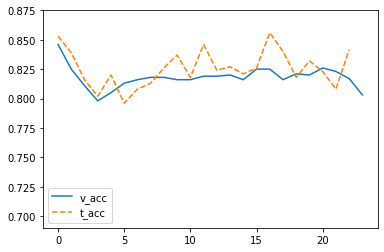

In [ ]:
plt.plot(v_acc)
plt.plot(t_acc, linestyle='--')
plt.legend(['v_acc', 't_acc'])
plt.ylim(0.690, 0.875)

plt.show()

In [ ]:
t_acc

In [ ]:
v_acc